In [24]:
import pathlib

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [5]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [6]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [7]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

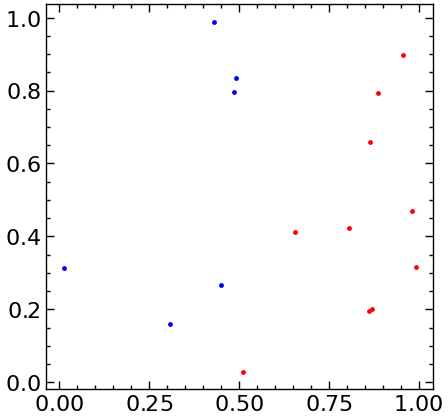

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [9]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [10]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [11]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.4305, 0.8664],
        [0.4305, 0.0127],
        [0.4305, 0.8870],
        [0.4305, 0.8063],
        [0.4305, 0.4923],
        [0.4305, 0.9925],
        [0.4305, 0.4517],
        [0.4305, 0.8715],
        [0.4305, 0.9822],
        [0.4305, 0.9562],
        [0.4305, 0.3085],
        [0.4305, 0.8623],
        [0.4305, 0.4865],
        [0.4305, 0.5112],
        [0.4305, 0.6577],
        [0.8664, 0.0127],
        [0.8664, 0.8870],
        [0.8664, 0.8063],
        [0.8664, 0.4923],
        [0.8664, 0.9925],
        [0.8664, 0.4517],
        [0.8664, 0.8715],
        [0.8664, 0.9822],
        [0.8664, 0.9562],
        [0.8664, 0.3085],
        [0.8664, 0.8623],
        [0.8664, 0.4865],
        [0.8664, 0.5112],
        [0.8664, 0.6577],
        [0.0127, 0.8870],
        [0.0127, 0.8063],
        [0.0127, 0.4923],
        [0.0127, 0.9925],
        [0.0127, 0.4517],
        [0.0127, 0.8715],
        [0.0127, 0.9822],
        [0.0127, 0.9562],
        [0.0127, 0.3085],
        [0.0

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [12]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.4358, -0.4178,  0.4564,  0.3758,  0.0618,  0.5620,  0.0212,  0.4410,
         0.5517,  0.5257, -0.1220,  0.4318,  0.0560,  0.0806,  0.2272, -0.8536,
         0.0206, -0.0601, -0.3740,  0.1261, -0.4146,  0.0051,  0.1159,  0.0899,
        -0.5579, -0.0041, -0.3799, -0.3552, -0.2087,  0.8742,  0.7935,  0.4796,
         0.9798,  0.4390,  0.8587,  0.9695,  0.9435,  0.2958,  0.8496,  0.4738,
         0.4984,  0.6450, -0.0807, -0.3946,  0.1056, -0.4352, -0.0155,  0.0953,
         0.0693, -0.5785, -0.0247, -0.4005, -0.3758, -0.2293, -0.3139,  0.1862,
        -0.3546,  0.0652,  0.1760,  0.1500, -0.4978,  0.0560, -0.3198, -0.2951,
        -0.1486,  0.5002, -0.0406,  0.3792,  0.4899,  0.4639, -0.1838,  0.3700,
        -0.0058,  0.0188,  0.1654, -0.5408, -0.1210, -0.0103, -0.0363, -0.6840,
        -0.1302, -0.5060, -0.4814, -0.3348,  0.4198,  0.5305,  0.5045, -0.1432,
         0.4106,  0.0348,  0.0594,  0.2060,  0.1108,  0.0848, -0.5630, -0.0092,
        -0.3850, -0.3603, -0.2138, -0.02

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [13]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.5469, 0.7946, 0.4962, 0.6801, 0.1663, 0.8779, 0.7231, 0.9026, 0.7587,
        0.5335, 0.8376, 0.9031, 0.2023, 0.9636, 0.6194, 0.9209, 0.1374, 0.2440,
        0.4134, 0.3664, 0.5709, 0.4572, 0.2230, 0.2561, 0.7480, 0.4629, 0.4035,
        0.7231, 0.3225, 0.9980, 0.8010, 0.7085, 0.9798, 0.4415, 0.8660, 0.9818,
        1.1103, 0.3329, 0.8576, 0.6755, 0.5738, 0.6526, 0.3810, 0.3967, 0.4914,
        0.6845, 0.5932, 0.3400, 0.1249, 0.8584, 0.5992, 0.4005, 0.8530, 0.4452,
        0.5184, 0.2150, 0.3873, 0.2301, 0.1819, 0.4993, 0.5624, 0.2332, 0.4910,
        0.4918, 0.1489, 0.7215, 0.5699, 0.7380, 0.6118, 0.4683, 0.6989, 0.7382,
        0.0404, 0.8061, 0.4531, 0.5430, 0.1657, 0.1539, 0.5849, 0.7012, 0.1763,
        0.6975, 0.5598, 0.3489, 0.4247, 0.5677, 0.8088, 0.1781, 0.4166, 0.5296,
        0.2448, 0.2528, 0.2888, 0.7021, 0.5645, 0.0108, 0.7072, 0.3996, 0.3006,
        0.4310, 0.7407, 0.2976, 0.5936, 0.6442, 0.3292, 0.9820, 0.7089, 0.4811,
        0.9769, 0.5700, 0.5549, 0.6588, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [14]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 5, 13],
        [ 8, 12]])

We will call all the particles in the left column "1" and the right column "2"

In [15]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [16]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [17]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [18]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

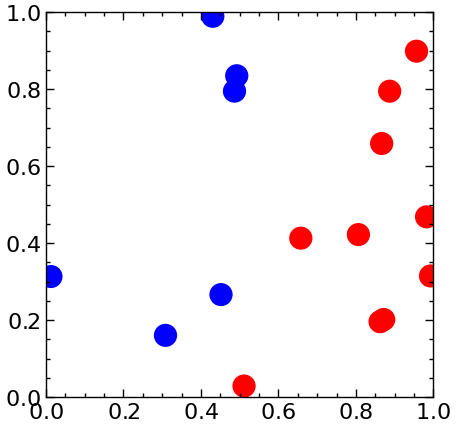

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

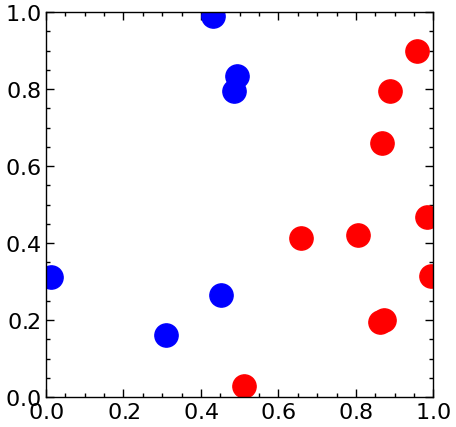

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
path = pathlib.Path('ani3.mp4')
# with open(path, "wb") as f:
#     pass
# ani.save(path, writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [28]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [29]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

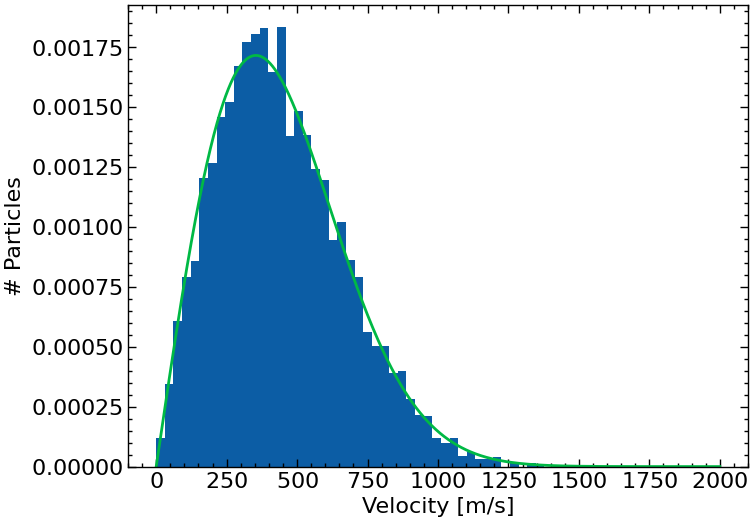

In [30]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

FileNotFoundError: [WinError 2] Не удается найти указанный файл

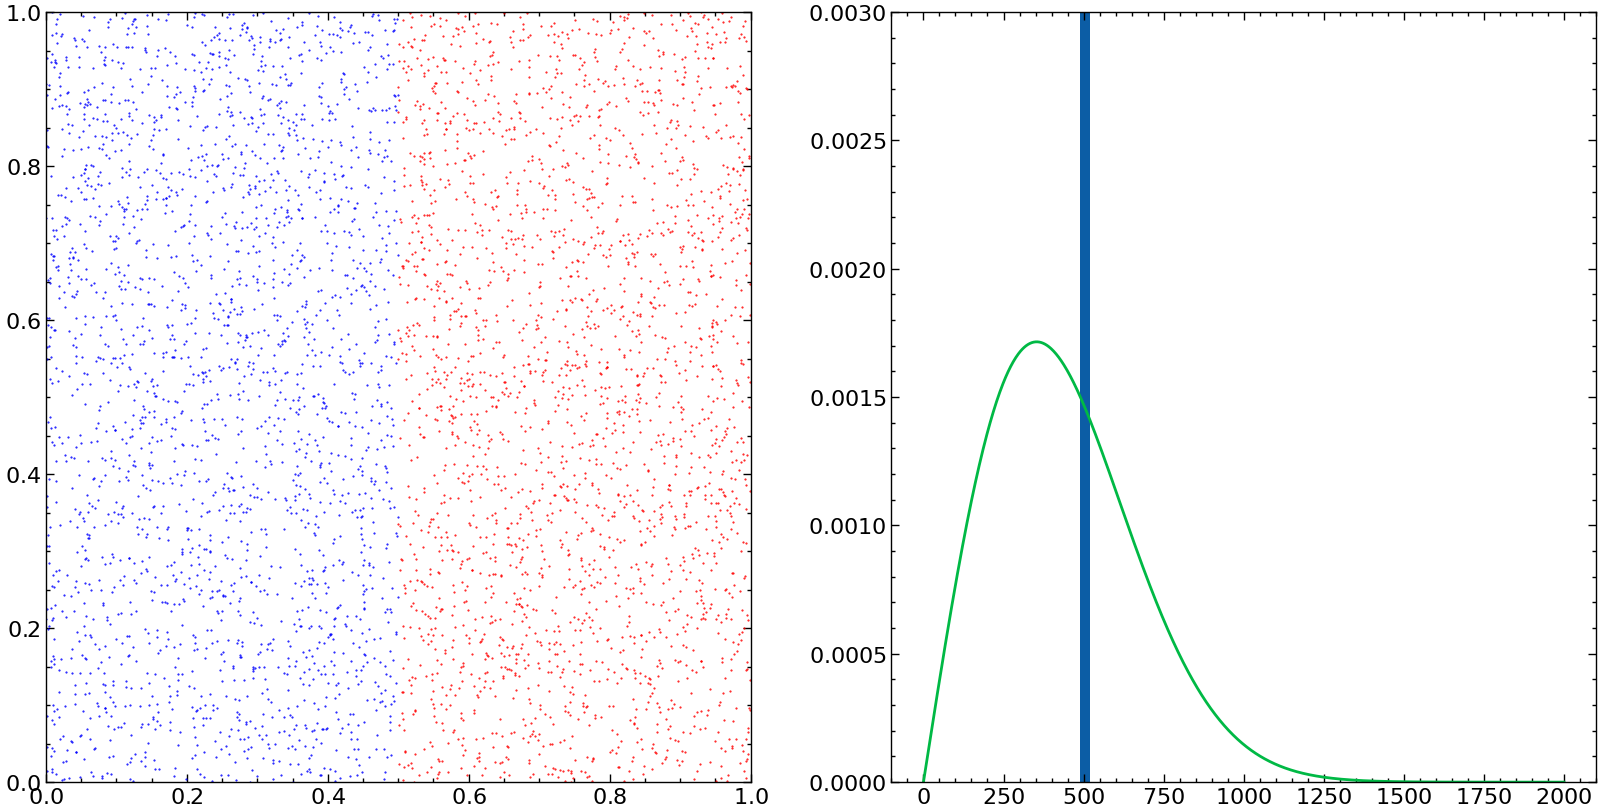

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)